## 1. Import Modules and Data
Accroding to original paper <a href="https://cdn.openai.com/research-covers/language-unsupervised/language_understanding_paper.pdf">Improving Language Understanding by Generative Pre-Training</a>, GPT can be fine-tined on Stanford Sentiment Treebank-2(SST2) dataset. More info about SST2 can be found [here](https://huggingface.co/datasets/stanfordnlp/sst2).

We add 3 new tokens to tokenizer: `<start>`, `<extract>` and `<pad>`, which will be added in raw sentences. Assume there is a batch size of 2:
```text
hide new secretions from the parental units
goes to absurd lengths
```
Before being fed to tokenizer, it will be processed as:
```
<start> hide new secretions from the parental units <extract>
<start> goes to absurd lengths <extract> <pad> <pad> <pad>
```

In [1]:
import config
from data import load_data

tokenizer, train_dataloader, valid_dataloader = load_data(
    "sst2", splits=["train", "validation"]
)

total_steps = (
    config.FinetuningConfig.n_epoch
    * len(train_dataloader)
    // config.FinetuningConfig.update_freq
)
warmup_steps = int(
    config.FinetuningConfig.warmup_steps
    * total_steps
    // config.FinetuningConfig.update_freq
)

total_steps, warmup_steps

(6315, 12)

## 2. Build Model and Load from Pre-trained

In [2]:
import torch

from modules import GPTClassifier
import config

device = torch.device("cuda:1")
n_classes = 2  # sst2 is a binary classification task
model = GPTClassifier.from_pretrained(
    config.pretrained_dir,
    num_frozen_layers=0, # all decoder layers is trainable
    n_classes=n_classes,
    vocab_size=40478 + 2,  # add 2 special tokens
).to(device)


number of parameters: 116.14M


## 3. Train Model
The hyperparameters used for fine-tuning are basically the same as those used for pre-training, except lr, number of epochs, batch_size and warmup steps. Also note that classification loss is weighted 0.5 by defaults, while language modelling loss is weighted 1.

### 3.2 Scheduler
The learning rate was increased linearly from zero over the first `warmup_steps` updates and annealed to 0 using a **linear** schedule.

Let's visualize its image.


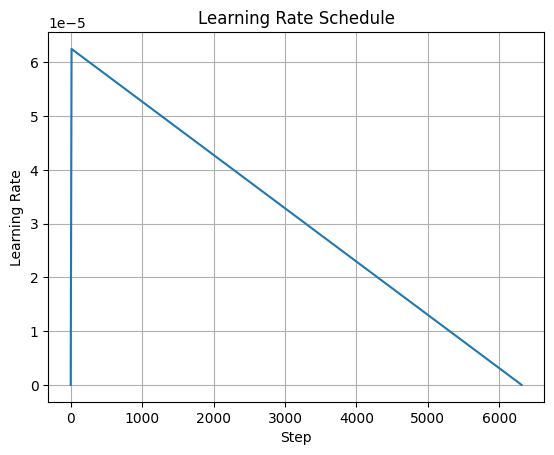

In [3]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
from transformers import get_linear_schedule_with_warmup

# dummy optimizer
optimizer = optim.AdamW(
    [torch.nn.Parameter(torch.randn((4, 4)))],
    lr=config.FinetuningConfig.lr,
)

scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_training_steps=total_steps,
    num_warmup_steps=warmup_steps,
)

lrs = []
for step in range(total_steps):
    optimizer.step()
    lrs.append(scheduler.get_last_lr())
    scheduler.step()

plt.plot(range(len(lrs)), lrs)
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")
plt.grid(True)
plt.show()

### 3.3 Train Loop

In [4]:
from tqdm.notebook import tqdm
import torch.nn as nn
from sklearn.metrics import accuracy_score

from data import pad_idx


def split_batch(batch):
    tokens, gt = batch
    src, tgt = tokens[:, :-1], tokens[:, 1:]
    tgt = tgt.masked_fill(tgt == pad_idx, -100)
    return src.to(device), tgt.to(device), gt.to(device)


@torch.no_grad()
def evaluate(model, lm_criterion, clf_criterion):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    for batch in tqdm(valid_dataloader, desc="Evaluating"):
        src, tgt, gt = split_batch(batch)

        pad_mask = (src != pad_idx)
        lm_logits, clf_logits = model(src, pad_mask)

        lm_loss = lm_criterion(
            lm_logits.contiguous().view(-1, tokenizer.get_vocab_size()), tgt.view(-1)
        )
        clf_loss = clf_criterion(clf_logits, gt)
        loss = lm_loss + config.FinetuningConfig.clf_loss_weight * clf_loss

        total_loss += loss.item()

        # collect predictions and labels for accuracy calculation
        preds = torch.argmax(clf_logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(gt.cpu().numpy())

    avg_loss = total_loss / len(valid_dataloader)
    accuracy = accuracy_score(all_labels, all_preds)

    return avg_loss, accuracy

In [5]:
def train(epoch, model, lm_criterion, clf_criterion, optimizer, scheduler):
    model.train()
    total_loss = 0
    step = 0
    optimizer.zero_grad()

    for batch in tqdm(train_dataloader, desc=f"Training Epoch {epoch}"):
        src, tgt, gt = split_batch(batch)

        # [batch_size, seq_len]
        pad_mask = (src != pad_idx)

        # [batch_size, seq_len - 1, vocab_size], [batch_size, n_classes]
        lm_logits, clf_logits = model(src, pad_mask)

        # [batch_size * (seq_len - 1), vocab_size]
        lm_logits = lm_logits.contiguous().view(-1, tokenizer.get_vocab_size())

        lm_loss = lm_criterion(lm_logits, tgt.contiguous().view(-1))
        clf_loss = clf_criterion(clf_logits, gt)

        loss = lm_loss + clf_loss * config.FinetuningConfig.clf_loss_weight
        loss.backward()

        if (step + 1) % config.FinetuningConfig.update_freq == 0 or (step + 1) == len(
            train_dataloader
        ):
            nn.utils.clip_grad_norm_(model.parameters(), config.clip)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        step += 1
        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)

    return avg_loss

In [6]:
import os


def training_loop(restore_epoch=-1):
    optimizer = model.configure_optimizers(
        lr=config.FinetuningConfig.lr,
        weight_decay=config.weight_decay,
        device_type=device.type,
    )
    scheduler = get_linear_schedule_with_warmup(
        optimizer=optimizer,
        num_training_steps=total_steps,
        num_warmup_steps=warmup_steps,
    )
    lm_criterion = nn.CrossEntropyLoss()
    clf_criterion = nn.CrossEntropyLoss()

    restore_ckpt_path = config.checkpoint_dir / f"gpt_clf_{restore_epoch}.pth"
    if restore_epoch != -1 and os.path.exists(restore_ckpt_path):
        ckpt = torch.load(restore_ckpt_path)
        assert ckpt["epoch"] == restore_epoch
        model.load_state_dict(ckpt["model"])
        optimizer.load_state_dict(ckpt["optimizer"])
        scheduler.load_state_dict(ckpt["scheduler"])
    else:
        restore_epoch = 0

    for epoch in range(restore_epoch, config.FinetuningConfig.n_epoch):
        avg_train_loss = train(
            epoch + 1, model, lm_criterion, clf_criterion, optimizer, scheduler
        )
        avg_valid_loss, avg_acc = evaluate(model, lm_criterion, clf_criterion)
        print(
            f"Epoch {epoch + 1}/{config.FinetuningConfig.n_epoch}, Training Loss: {avg_train_loss: .4f},",
            f"Validation Loss: {avg_valid_loss:.4f}, Accuracy: {avg_acc*100:.2f}",
        )

        checkpoint_path = config.checkpoint_dir / f"gpt_clf_{epoch + 1}.pth"
        torch.save(
            {
                "epoch": epoch + 1,
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
            },
            checkpoint_path,
        )


training_loop()

num decayed parameter tensors: 51, with 116,418,048 parameters
num non-decayed parameter tensors: 96, with 119,808 parameters
using fused AdamW: True


Training Epoch 1:   0%|          | 0/2105 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 1/3, Training Loss:  5.8038, Validation Loss: 5.1952, Accuracy: 80.16


Training Epoch 2:   0%|          | 0/2105 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 2/3, Training Loss:  4.1323, Validation Loss: 5.0189, Accuracy: 82.22


Training Epoch 3:   0%|          | 0/2105 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 3/3, Training Loss:  3.7279, Validation Loss: 4.9744, Accuracy: 83.72
